<a href="https://colab.research.google.com/github/sreekar2003/Email-Spam-Detection-Using-Machiine-Learning-Algorithms/blob/main/Email_Spam_Detection_Using_Machine_Learning_Algorithms_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Loading the dataset
df = pd.read_csv("messages.csv",encoding='latin-1')

In [5]:
df.head()


,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [6]:
#Checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [7]:
#Checking the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2893, 3)


In [8]:
#Checking for the null values
df.isnull().values.any()

True

In [9]:
#Checkin for the null values in columns
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [10]:
# 62 row are missing in the subject columns that means 62 emails are without subject heading.
# Here, not dropping Nan rows for subject column as it of no use in building model.

In [11]:
#Checking total number of mails
print("Count of label:\n",df['label'].value_counts())

Count of label:
 0    2412
1     481
Name: label, dtype: int64


In [12]:
# Note:- Here in our dataset 1 stands for Spam mail and 0 stands for not a spam mail.
#Checking the Ratio of labels
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 83.0 %
Spam Email Ratio that is 1 label: 17.0 %


In [13]:
# so here 17 % of the data is a spam email

In [14]:
#Creating the new column for length of message column
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [15]:
#Converting all messages to lower case
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [16]:
# regular expressions
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
   
# Replace numeric characters with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [17]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [18]:
# now re-checking the data
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [19]:
#Removing the stopwords
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [ ]:
# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.message.str.len()
df.head()

In [22]:
#Total length removal
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 9344743
Cleaned Length: 6767857
Total Words Removed: 2576886


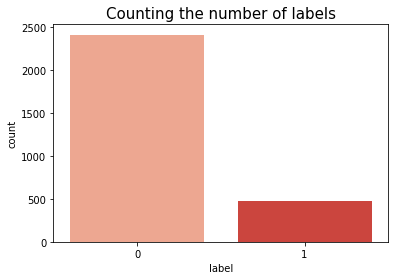

0    2412
1     481
Name: label, dtype: int64


In [23]:
#Graphical Visualisation for counting number of labels.
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(df.label.value_counts())

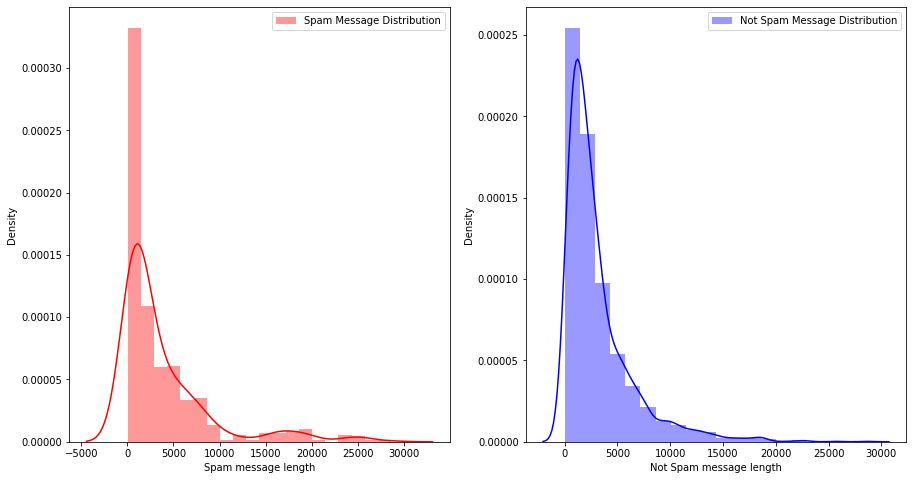

In [24]:
#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

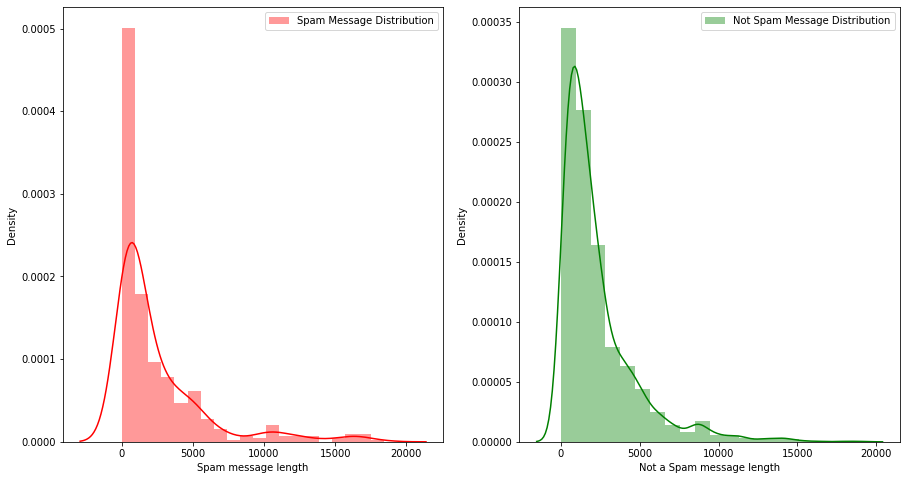

In [25]:
#Message distribution after cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

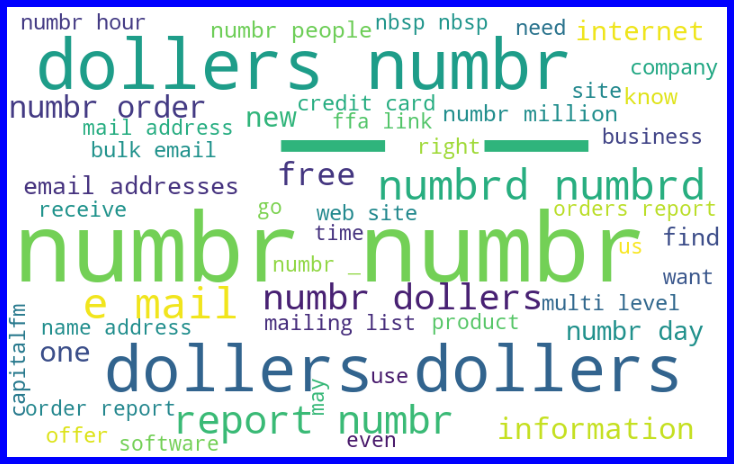

In [26]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

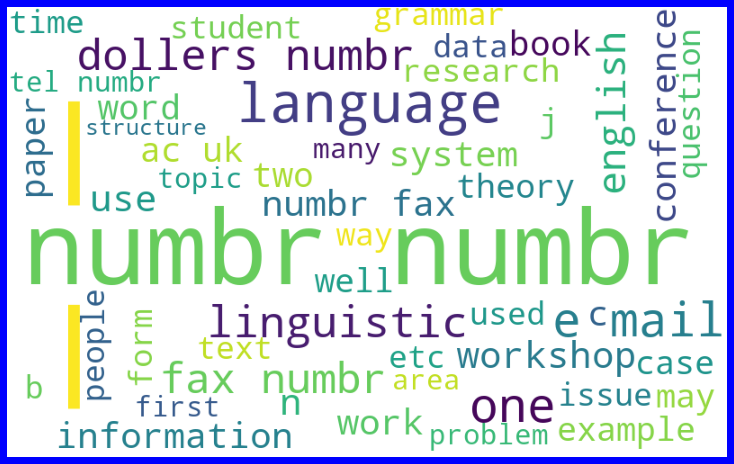

In [27]:
#Getting sense of loud words in not-spam 
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [28]:
# Converting the text into vectors using TF-IDF, as text cannot be the input in the model
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label


tf_vec = TfidfVectorizer()

naive = MultinomialNB()

SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

decision = DecisionTreeClassifier()
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")

clf = LogisticRegression()


features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [29]:
# Train and predict for naive bayes model
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)        

#test_size=0.20 random_state=42 test_size=0.15

naive.fit(X_train,Y_train)
y_pred= naive.predict(x_test)



print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8342541436464088


In [30]:
# Train and predict for SVM model
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)        

#test_size=0.20 random_state=42 test_size=0.15



SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9875690607734806


In [31]:
# train and predict for the Decision tree model
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
decision.fit(X_train,Y_train)
#test_size=0.20 random_state=42 test_size=0.15

y_pred = decision.predict(x_test)
print ('Final score = > ', accuracy_score(y_test,y_pred))



Final score = >  0.9558011049723757


In [32]:
# train and predict uisng random forest classifier
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
classifier.fit(X_train, Y_train)  
#test_size=0.20 random_state=42 test_size=0.15
y_pred= classifier.predict(x_test)  
print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.962707182320442


In [33]:
# train and predict uisng logistic regression
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
clf.fit(X_train, Y_train)
#test_size=0.20 random_state=42 test_size=0.15
y_pred= clf.predict(x_test)  
print ('Final score = > ', accuracy_score(y_test,y_pred))


Final score = >  0.9475138121546961


In [34]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

[Text(0.8492647058823529, 0.9827586206896551, 'X[18089] <= 0.015\ngini = 0.266\nsamples = 2169\nvalue = [1827, 342]'),
 Text(0.7612745098039215, 0.9482758620689655, 'X[41154] <= 0.009\ngini = 0.157\nsamples = 1901\nvalue = [1738, 163]'),
 Text(0.6950980392156862, 0.9137931034482759, 'X[32052] <= 0.076\ngini = 0.12\nsamples = 1853\nvalue = [1734, 119]'),
 Text(0.6411764705882353, 0.8793103448275862, 'X[8614] <= 0.053\ngini = 0.1\nsamples = 1828\nvalue = [1732, 96]'),
 Text(0.5803921568627451, 0.8448275862068966, 'X[19527] <= 0.068\ngini = 0.08\nsamples = 1804\nvalue = [1729, 75]'),
 Text(0.5372549019607843, 0.8103448275862069, 'X[23195] <= 0.019\ngini = 0.065\nsamples = 1780\nvalue = [1720, 60]'),
 Text(0.4980392156862745, 0.7758620689655172, 'X[49044] <= 0.029\ngini = 0.057\nsamples = 1771\nvalue = [1719, 52]'),
 Text(0.4666666666666667, 0.7413793103448276, 'X[51790] <= 0.083\ngini = 0.049\nsamples = 1760\nvalue = [1716, 44]'),
 Text(0.45098039215686275, 0.7068965517241379, 'X[7268] <=

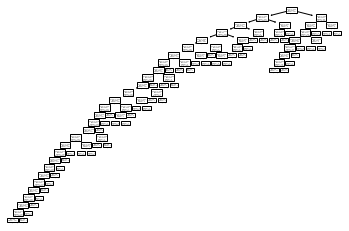

In [35]:
tree.plot_tree(decision)

In [36]:
# Checking Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       585
           1       0.99      0.73      0.84       139

    accuracy                           0.95       724
   macro avg       0.97      0.87      0.91       724
weighted avg       0.95      0.95      0.94       724



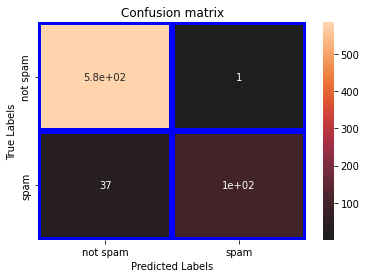

In [37]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

In [38]:
# SVM performs best among all the classification models